#### 环境配置

In [ ]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

In [ ]:
# install dependencies: (if your colab has CUDA 11.8)
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
# install MMEngine, MMCV and MMDetection using MIM
%pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"
!mim install "mmdet>=3.0.0"

In [ ]:
# for better Colab compatibility, install xtcocotools from source
%pip install git+https://github.com/jin-s13/xtcocoapi

In [ ]:
# %cd /content/drive/MyDrive  # download to your Google Drive
# !git clone https://github.com/open-mmlab/mmpose.git
%cd /content/drive/MyDrive/mmpose
%pip install -r requirements.txt
%pip install -v -e .

In [6]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 2.0.1+cu118 False
torchvision version: 0.15.2+cu118
mmpose version: 1.0.0
cuda version: 11.8
compiler information: GCC 9.3


#### 验证安装成功

In [7]:
import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope
import numpy as np

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

img = 'tests/data/coco/000000197388.jpg'
pose_config = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

device = 'cpu'
cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=True)))


# build detector
detector = init_detector(det_config, det_checkpoint, device=device)

# build pose estimator
pose_estimator = init_pose_estimator(pose_config, pose_checkpoint,
    device=device, cfg_options=cfg_options)

# init visualizer
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.line_width = 1

visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


Downloading: "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth" to /root/.cache/torch/hub/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


Downloading: "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w32_coco_256x192-c78dce93_20200708.pth


06/03 12:42:00 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [8]:
def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file):
    """Visualize predicted keypoints (and heatmaps) of one image."""

    # predict bbox
    init_default_scope(detector.cfg.get('default_scope', 'mmdet'))
    detect_result = inference_detector(detector, img_path)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img_path, bboxes)
    data_samples = merge_data_samples(pose_results)

    # show the results
    img = mmcv.imread(img_path, channel_order='rgb')

    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_thr=0.3)

In [9]:
visualize_img(
    img,
    detector,
    pose_estimator,
    visualizer,
    show_interval=0,
    out_file=None)

vis_result = visualizer.get_image()

06/03 12:42:00 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".
06/03 12:42:11 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


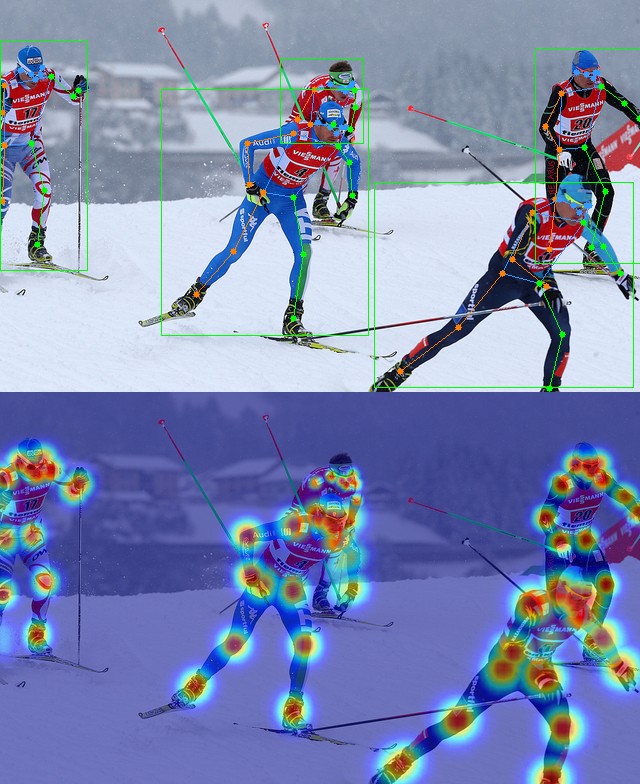

In [10]:
cv2_imshow(vis_result[:,:,::-1]) #RGB2BGR to fit cv2

#### 训练目标检测模型

In [ ]:
# %pwd
# %mkdir work_dir
# from mmengine.config import Config, DictAction
# from mmengine.runner import Runner

# det_cfg = Config.fromfile('rtmdet_tiny_ear.py')
# det_cfg.work_dir = 'rtmdet_tiny_ear'
# runner = Runner.from_cfg(det_cfg)

# # start training
# runner.train()

#### 使用自己耳朵的图像预测

Loads checkpoint by local backend from path: /content/drive/MyDrive/mmpose/rtmdet_tiny_ear/epoch_70.pth


/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


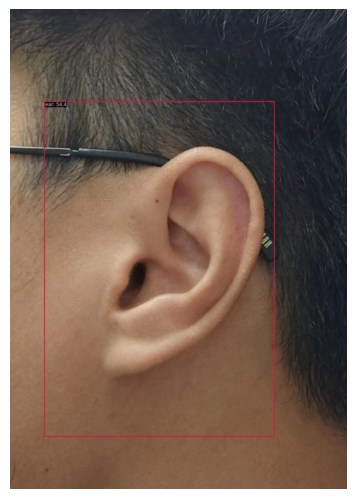

In [18]:
rtmdet = init_detector(
    config='/content/drive/MyDrive/mmpose/rtmdet_tiny_ear.py',
    checkpoint='/content/drive/MyDrive/mmpose/rtmdet_tiny_ear/epoch_70.pth',
    device=device)


from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook) 
visualizer = VISUALIZERS.build(rtmdet.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = rtmdet.dataset_meta # 注意修改为本模型的数据集信息

image = mmcv.imread('MyEar.jpg', channel_order='rgb')
det_result = inference_detector(rtmdet, image)
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=det_result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()


#### 训练RTMPose

In [ ]:
# !python tools/train.py rtmpose-s-ear.py

In [20]:
rtmpose = init_pose_estimator(
    config='/content/drive/MyDrive/mmpose/rtmpose-s-ear.py',
    checkpoint='/content/drive/MyDrive/mmpose/work_dirs/rtmpose-s-ear/best_PCK_epoch_80.pth',
    device=device)

from mmpose.registry import VISUALIZERS

visualizer = VISUALIZERS.build(rtmpose.cfg.visualizer)
visualizer.set_dataset_meta(rtmpose.dataset_meta)

def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file):
    """Visualize predicted keypoints (and heatmaps) of one image."""

    # predict bbox
    img = mmcv.imread(img_path, channel_order='rgb')
    init_default_scope(detector.cfg.get('default_scope', 'mmdet'))
    detect_result = inference_detector(detector, img)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img, bboxes)
    data_samples = merge_data_samples(pose_results)

    # show the results
    

    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_thr=0.3)

visualize_img(
    '/content/drive/MyDrive/mmpose/MyEar.jpg',
    rtmdet,
    rtmpose,
    visualizer,
    show_interval=0,
    out_file=None)

vis_result = visualizer.get_image()
cv2_imshow(vis_result[:,:,::-1]) #RGB2BGR to fit cv2

Output hidden; open in https://colab.research.google.com to view.